In [32]:
import numpy as np
from scipy.misc import imsave
from scipy.optimize import fmin_l_bfgs_b
import time
from keras.preprocessing.image import load_img,img_to_array
from keras.applications import vgg16
from keras import backend as K
from keras.layers import Input
from matplotlib import pyplot as plt
%matplotlib inline
from keras.applications.inception_v3 import InceptionV3,preprocess_input

In [33]:
K.set_learning_phase(0)

In [34]:
img_path='star.jpg'
img_width,img_height=600,400
img_size=(img_height,img_width,3)
dream=Input(batch_shape=(1,)+img_size)

In [35]:
model=vgg16.VGG16(input_tensor=dream, weights='imagenet',include_top=False)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (1, 400, 600, 3)          0         
_________________________________________________________________
block1_conv1 (Conv2D)        (1, 400, 600, 64)         1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (1, 400, 600, 64)         36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (1, 200, 300, 64)         0         
_________________________________________________________________
block2_conv1 (Conv2D)        (1, 200, 300, 128)        73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (1, 200, 300, 128)        147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (1, 100, 150, 128)        0         
__________

In [36]:
def preprocess(img_path):
    img=load_img(img_path,target_size=(img_height,img_width))
    #img = np.asarray(255*np.random.random((img_height, img_width, 3)), dtype='uint8')
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg16.preprocess_input(img)
    return img

In [37]:
def deprocess(x):
    x=x.reshape((img_height,img_width,3))
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [38]:
layer_dict=dict([ (layer.name,layer) for layer in model.layers])


In [40]:
layer_out=layer_dict['block5_conv2'].output
#layer_out_1=layer_dict['conv2d_68'].output
loss=-K.mean(layer_out[:,:,:,:15])
#loss=-K.mean(layer_out_1[:,:,:,:5])

In [41]:
grads=K.gradients(loss,dream)

output=[loss]
if isinstance(grads, (list, tuple)):
    output += grads
else:
    output.append(grads)
f_outputs=K.function([dream],output)    

In [42]:
def eval_loss_and_grads(x):
    x = x.reshape((1,) + img_size)
    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values


class Evaluator(object):
    def __init__(self):
        self.loss_value = None
        self.grad_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

In [43]:
settings={
    'jitter':0.5,
}

In [ ]:
#from keras.applications.inception_v3 import InceptionV3,preprocess_input

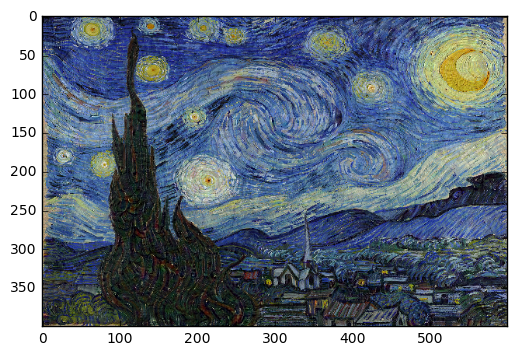

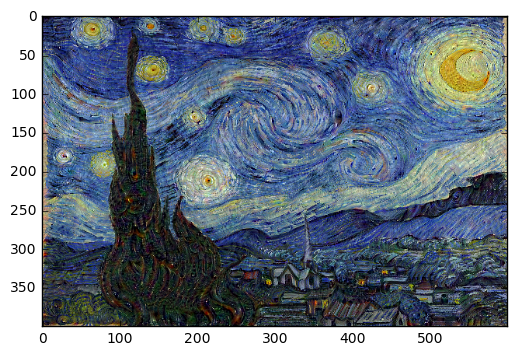

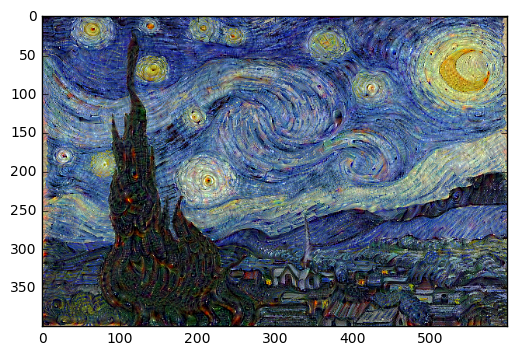

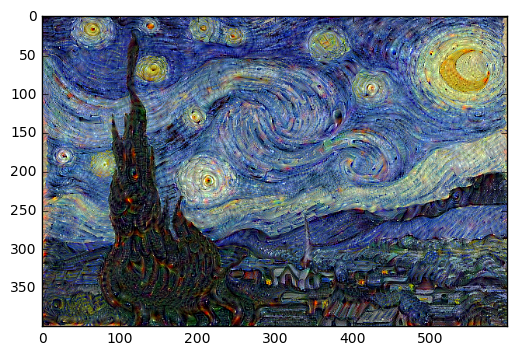

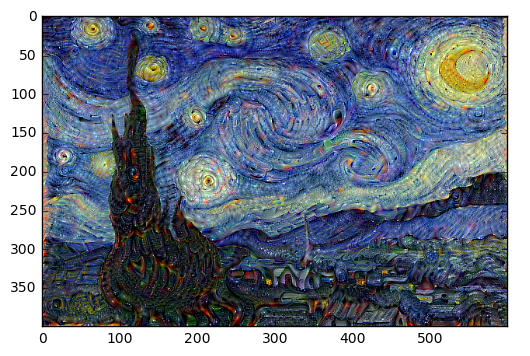

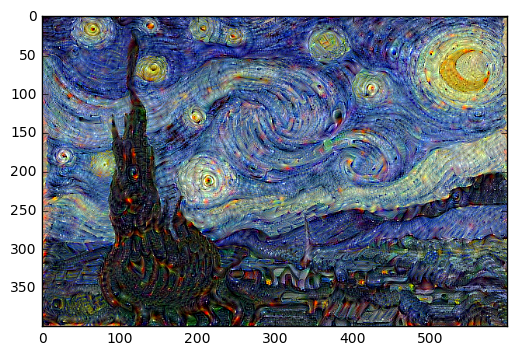

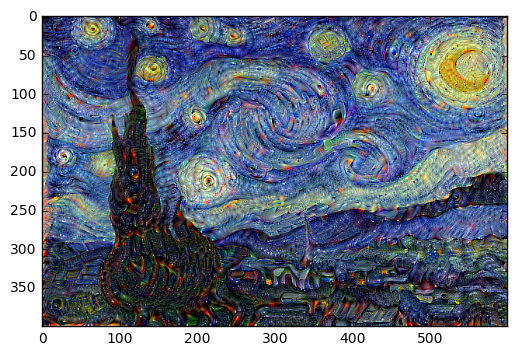

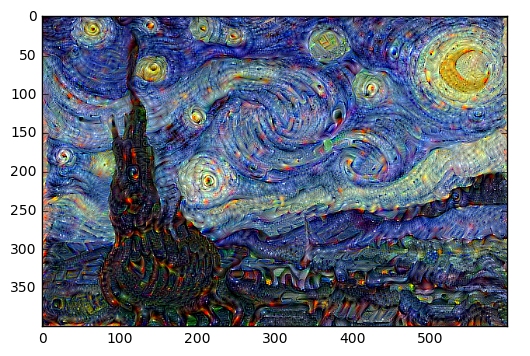

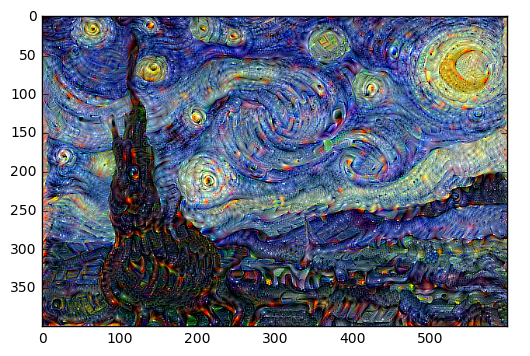

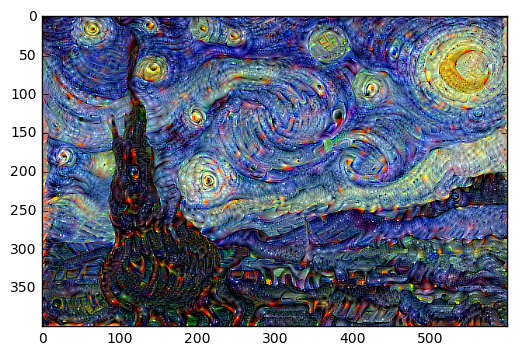

In [44]:
x=preprocess('star.jpg')
for ix in range(10):
    random_jitter=(settings['jitter']*2)*(np.random.random(img_size))
    x+=random_jitter
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=7)
    x = x.reshape(img_size)
    x -= random_jitter
    img = deprocess(np.copy(x))

    plt.imshow(img)
    plt.show()